# Method 5 - Best Fresh Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Novus HFU

novus_hfu = hfu.get_novus_hfu()

# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

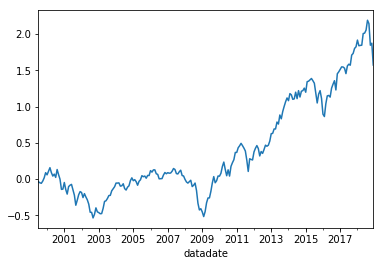

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.088130
2000-12-31   -0.208346
2001-12-31   -0.039657
2002-12-31   -0.337355
2003-12-31    0.631543
2004-12-31    0.136864
2005-12-31    0.031383
2006-12-31    0.023670
2007-12-31   -0.028716
2008-12-31   -0.432444
2009-12-31    0.761145
2010-12-31    0.311620
2011-12-31   -0.075815
2012-12-31    0.206480
2013-12-31    0.389846
2014-12-31    0.063887
2015-12-31   -0.062955
2016-12-31    0.173619
2017-12-31    0.138969
2018-12-31   -0.088842
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     632.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.81e-122
Time:                        05:47:42   Log-Likelihood:                 606.73
No. Observations:                 234   AIC:                            -1203.
Df Residuals:                     229   BIC:                            -1186.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.526      0.128      -0.001       0.004
mktrf          1.1063      0.034     32.419      0.000       1.039       1.174
me             0.2614      0.040      6.586      0.000       0.183       0.340
ia             0.1963      0.060      3.254      0.001       0.077       0.315
roe           -0.4704      0.052     -9.108      0.000      -0.572      -0.369
==============================================================================
Omnibus:                       33.238   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.372
Skew:                           0.431   Prob(JB):                     3.30e-31
Kurtosis:                       6.695   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     317.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.77e-92
Time:                        05:47:42   Log-Likelihood:                 606.73
No. Observations:                 234   AIC:                            -1203.
Df Residuals:                     229   BIC:                            -1186.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.412      0.158      -0.001       0.005
mktrf          1.1063      0.057     19.390      0.000       0.994       1.218
me             0.2614      0.129      2.024      0.043       0.008       0.515
ia             0.1963      0.120      1.631      0.103      -0.040       0.432
roe           -0.4704      0.101     -4.658      0.000      -0.668      -0.272
==============================================================================
Omnibus:                       33.238   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.372
Skew:                           0.431   Prob(JB):                     3.30e-31
Kurtosis:                       6.695   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     291.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.41e-88
Time:                        05:47:42   Log-Likelihood:                 606.73
No. Observations:                 234   AIC:                            -1203.
Df Residuals:                     229   BIC:                            -1186.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.384      0.166      -0.001       0.005
mktrf          1.1063      0.059     18.779      0.000       0.991       1.222
me             0.2614      0.137      1.908      0.056      -0.007       0.530
ia             0.1963      0.117      1.682      0.093      -0.032       0.425
roe           -0.4704      0.110     -4.292      0.000      -0.685      -0.256
==============================================================================
Omnibus:                       33.238   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.372
Skew:                           0.431   Prob(JB):                     3.30e-31
Kurtosis:                       6.695   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     445.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.66e-115
Time:                        05:47:42   Log-Likelihood:                 593.63
No. Observations:                 234   AIC:                            -1175.
Df Residuals:                     228   BIC:                            -1155.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.871      0.385      -0.001       0.004
mktrf          1.1551      0.036     31.872      0.000       1.084       1.226
smb            0.3385      0.048      7.079      0.000       0.244       0.433
hml            0.2747      0.056      4.872      0.000       0.164       0.386
rmw           -0.3309      0.064     -5.191      0.000      -0.457      -0.205
cma           -0.1019      0.081     -1.257      0.210      -0.262       0.058
==============================================================================
Omnibus:                       43.303   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.092
Skew:                           0.713   Prob(JB):                     2.56e-33
Kurtosis:                       6.655   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     237.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.49e-88
Time:                        05:47:42   Log-Likelihood:                 593.63
No. Observations:                 234   AIC:                            -1175.
Df Residuals:                     228   BIC:                            -1155.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.726      0.468      -0.002       0.004
mktrf          1.1551      0.050     23.078      0.000       1.057       1.253
smb            0.3385      0.117      2.902      0.004       0.110       0.567
hml            0.2747      0.103      2.656      0.008       0.072       0.477
rmw           -0.3309      0.123     -2.695      0.007      -0.572      -0.090
cma           -0.1019      0.173     -0.588      0.557      -0.442       0.238
==============================================================================
Omnibus:                       43.303   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.092
Skew:                           0.713   Prob(JB):                     2.56e-33
Kurtosis:                       6.655   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     254.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.86e-91
Time:                        05:47:42   Log-Likelihood:                 593.63
No. Observations:                 234   AIC:                            -1175.
Df Residuals:                     228   BIC:                            -1155.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.660      0.509      -0.002       0.005
mktrf          1.1551      0.050     23.212      0.000       1.058       1.253
smb            0.3385      0.115      2.954      0.003       0.114       0.563
hml            0.2747      0.091      3.004      0.003       0.095       0.454
rmw           -0.3309      0.130     -2.537      0.011      -0.587      -0.075
cma           -0.1019      0.176     -0.579      0.563      -0.447       0.243
==============================================================================
Omnibus:                       43.303   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.092
Skew:                           0.713   Prob(JB):                     2.56e-33
Kurtosis:                       6.655   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     802.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.12e-133
Time:                        05:47:42   Log-Likelihood:                 632.46
No. Observations:                 234   AIC:                            -1255.
Df Residuals:                     229   BIC:                            -1238.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.849      0.397      -0.001       0.003
mktrf          1.1210      0.028     39.827      0.000       1.066       1.176
smb            0.5113      0.035     14.553      0.000       0.442       0.581
hml            0.1398      0.035      4.007      0.000       0.071       0.209
umd           -0.2695      0.023    -11.770      0.000      -0.315      -0.224
==============================================================================
Omnibus:                       24.203   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.184
Skew:                           0.541   Prob(JB):                     9.36e-11
Kurtosis:                       4.888   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     435.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.77e-106
Time:                        05:47:42   Log-Likelihood:                 632.46
No. Observations:                 234   AIC:                            -1255.
Df Residuals:                     229   BIC:                            -1238.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.823      0.411      -0.001       0.003
mktrf          1.1210      0.033     34.184      0.000       1.057       1.185
smb            0.5113      0.084      6.069      0.000       0.346       0.676
hml            0.1398      0.050      2.790      0.005       0.042       0.238
umd           -0.2695      0.041     -6.532      0.000      -0.350      -0.189
==============================================================================
Omnibus:                       24.203   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.184
Skew:                           0.541   Prob(JB):                     9.36e-11
Kurtosis:                       4.888   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     376.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.89e-99
Time:                        05:47:42   Log-Likelihood:                 632.46
No. Observations:                 234   AIC:                            -1255.
Df Residuals:                     229   BIC:                            -1238.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.870      0.384      -0.001       0.003
mktrf          1.1210      0.036     31.238      0.000       1.051       1.191
smb            0.5113      0.091      5.589      0.000       0.332       0.691
hml            0.1398      0.046      3.068      0.002       0.051       0.229
umd           -0.2695      0.039     -6.838      0.000      -0.347      -0.192
==============================================================================
Omnibus:                       24.203   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.184
Skew:                           0.541   Prob(JB):                     9.36e-11
Kurtosis:                       4.888   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     312.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.13e-61
Time:                        05:47:42   Log-Likelihood:                 294.95
No. Observations:                 120   AIC:                            -579.9
Df Residuals:                     115   BIC:                            -566.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.449      0.150      -0.001       0.007
mktrf          1.1162      0.055     20.465      0.000       1.008       1.224
me             0.1419      0.054      2.633      0.010       0.035       0.249
ia             0.2152      0.084      2.551      0.012       0.048       0.382
roe           -0.4916      0.075     -6.583      0.000      -0.639      -0.344
==============================================================================
Omnibus:                        2.812   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.821
Skew:                           0.018   Prob(JB):                        0.244
Kurtosis:                       3.750   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     183.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.47e-49
Time:                        05:47:42   Log-Likelihood:                 294.95
No. Observations:                 120   AIC:                            -579.9
Df Residuals:                     115   BIC:                            -566.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.363      0.173      -0.001       0.007
mktrf          1.1162      0.068     16.520      0.000       0.984       1.249
me             0.1419      0.122      1.159      0.247      -0.098       0.382
ia             0.2152      0.131      1.647      0.100      -0.041       0.471
roe           -0.4916      0.110     -4.469      0.000      -0.707      -0.276
==============================================================================
Omnibus:                        2.812   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.821
Skew:                           0.018   Prob(JB):                        0.244
Kurtosis:                       3.750   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     157.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.88e-46
Time:                        05:47:43   Log-Likelihood:                 294.95
No. Observations:                 120   AIC:                            -579.9
Df Residuals:                     115   BIC:                            -566.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.415      0.157      -0.001       0.007
mktrf          1.1162      0.070     15.968      0.000       0.979       1.253
me             0.1419      0.129      1.100      0.271      -0.111       0.395
ia             0.2152      0.128      1.688      0.092      -0.035       0.465
roe           -0.4916      0.118     -4.162      0.000      -0.723      -0.260
==============================================================================
Omnibus:                        2.812   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.821
Skew:                           0.018   Prob(JB):                        0.244
Kurtosis:                       3.750   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     202.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.90e-55
Time:                        05:47:43   Log-Likelihood:                 283.93
No. Observations:                 120   AIC:                            -555.9
Df Residuals:                     114   BIC:                            -539.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.183      0.239      -0.002       0.007
mktrf          1.2303      0.063     19.430      0.000       1.105       1.356
smb            0.2463      0.072      3.435      0.001       0.104       0.388
hml            0.2129      0.088      2.423      0.017       0.039       0.387
rmw           -0.2832      0.104     -2.733      0.007      -0.489      -0.078
cma           -0.0513      0.114     -0.452      0.652      -0.276       0.174
==============================================================================
Omnibus:                       11.536   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.854
Skew:                           0.478   Prob(JB):                     0.000219
Kurtosis:                       4.568   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     98.07
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-39
Time:                        05:47:43   Log-Likelihood:                 283.93
No. Observations:                 120   AIC:                            -555.9
Df Residuals:                     114   BIC:                            -539.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.003      1.059      0.290      -0.002       0.008
mktrf          1.2303      0.072     17.184      0.000       1.090       1.371
smb            0.2463      0.142      1.734      0.083      -0.032       0.525
hml            0.2129      0.097      2.194      0.028       0.023       0.403
rmw           -0.2832      0.124     -2.284      0.022      -0.526      -0.040
cma           -0.0513      0.205     -0.251      0.802      -0.452       0.349
==============================================================================
Omnibus:                       11.536   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.854
Skew:                           0.478   Prob(JB):                     0.000219
Kurtosis:                       4.568   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     86.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.87e-37
Time:                        05:47:43   Log-Likelihood:                 283.93
No. Observations:                 120   AIC:                            -555.9
Df Residuals:                     114   BIC:                            -539.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.003      1.012      0.312      -0.003       0.008
mktrf          1.2303      0.069     17.893      0.000       1.096       1.365
smb            0.2463      0.133      1.853      0.064      -0.014       0.507
hml            0.2129      0.090      2.358      0.018       0.036       0.390
rmw           -0.2832      0.129     -2.194      0.028      -0.536      -0.030
cma           -0.0513      0.206     -0.249      0.803      -0.456       0.353
==============================================================================
Omnibus:                       11.536   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.854
Skew:                           0.478   Prob(JB):                     0.000219
Kurtosis:                       4.568   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     413.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.05e-67
Time:                        05:47:43   Log-Likelihood:                 310.53
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.124      0.263      -0.001       0.005
mktrf          1.1561      0.042     27.396      0.000       1.073       1.240
smb            0.4382      0.048      9.119      0.000       0.343       0.533
hml            0.0978      0.048      2.032      0.044       0.002       0.193
umd           -0.2680      0.030     -9.034      0.000      -0.327      -0.209
==============================================================================
Omnibus:                        3.737   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.312
Skew:                           0.275   Prob(JB):                        0.191
Kurtosis:                       3.600   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     306.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.58e-60
Time:                        05:47:43   Log-Likelihood:                 310.53
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.086      0.277      -0.002       0.005
mktrf          1.1561      0.049     23.403      0.000       1.059       1.253
smb            0.4382      0.090      4.875      0.000       0.262       0.614
hml            0.0978      0.063      1.549      0.121      -0.026       0.221
umd           -0.2680      0.045     -5.989      0.000      -0.356      -0.180
==============================================================================
Omnibus:                        3.737   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.312
Skew:                           0.275   Prob(JB):                        0.191
Kurtosis:                       3.600   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     454.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.95e-69
Time:                        05:47:43   Log-Likelihood:                 310.53
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.233      0.218      -0.001       0.005
mktrf          1.1561      0.053     21.966      0.000       1.053       1.259
smb            0.4382      0.099      4.410      0.000       0.243       0.633
hml            0.0978      0.066      1.487      0.137      -0.031       0.227
umd           -0.2680      0.041     -6.572      0.000      -0.348      -0.188
==============================================================================
Omnibus:                        3.737   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.312
Skew:                           0.275   Prob(JB):                        0.191
Kurtosis:                       3.600   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     513.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.90e-70
Time:                        05:47:43   Log-Likelihood:                 346.40
No. Observations:                 114   AIC:                            -682.8
Df Residuals:                     109   BIC:                            -669.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.139      0.035       0.000       0.005
mktrf          1.0054      0.035     28.850      0.000       0.936       1.075
me             0.6431      0.054     11.951      0.000       0.536       0.750
ia             0.1015      0.075      1.359      0.177      -0.046       0.249
roe           -0.4516      0.066     -6.886      0.000      -0.582      -0.322
==============================================================================
Omnibus:                      121.243   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2717.908
Skew:                           3.480   Prob(JB):                         0.00
Kurtosis:                      25.886   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     434.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.67e-66
Time:                        05:47:43   Log-Likelihood:                 346.40
No. Observations:                 114   AIC:                            -682.8
Df Residuals:                     109   BIC:                            -669.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.945      0.052   -1.89e-05       0.005
mktrf          1.0054      0.031     32.602      0.000       0.945       1.066
me             0.6431      0.053     12.060      0.000       0.539       0.748
ia             0.1015      0.081      1.252      0.210      -0.057       0.260
roe           -0.4516      0.101     -4.454      0.000      -0.650      -0.253
==============================================================================
Omnibus:                      121.243   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2717.908
Skew:                           3.480   Prob(JB):                         0.00
Kurtosis:                      25.886   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     497.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.25e-69
Time:                        05:47:43   Log-Likelihood:                 346.40
No. Observations:                 114   AIC:                            -682.8
Df Residuals:                     109   BIC:                            -669.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.987      0.047    3.47e-05       0.005
mktrf          1.0054      0.030     33.098      0.000       0.946       1.065
me             0.6431      0.062     10.348      0.000       0.521       0.765
ia             0.1015      0.080      1.270      0.204      -0.055       0.258
roe           -0.4516      0.100     -4.508      0.000      -0.648      -0.255
==============================================================================
Omnibus:                      121.243   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2717.908
Skew:                           3.480   Prob(JB):                         0.00
Kurtosis:                      25.886   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     371.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.61e-66
Time:                        05:47:43   Log-Likelihood:                 341.44
No. Observations:                 114   AIC:                            -670.9
Df Residuals:                     108   BIC:                            -654.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.060      0.291      -0.001       0.004
mktrf          1.0328      0.035     29.613      0.000       0.964       1.102
smb            0.5978      0.057     10.559      0.000       0.486       0.710
hml            0.2469      0.072      3.420      0.001       0.104       0.390
rmw           -0.3978      0.088     -4.499      0.000      -0.573      -0.223
cma           -0.0468      0.112     -0.417      0.678      -0.269       0.176
==============================================================================
Omnibus:                       78.174   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.985
Skew:                           2.184   Prob(JB):                    2.58e-132
Kurtosis:                      13.416   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     391.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.74e-67
Time:                        05:47:43   Log-Likelihood:                 341.44
No. Observations:                 114   AIC:                            -670.9
Df Residuals:                     108   BIC:                            -654.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.863      0.388      -0.002       0.004
mktrf          1.0328      0.027     38.704      0.000       0.980       1.085
smb            0.5978      0.056     10.637      0.000       0.488       0.708
hml            0.2469      0.128      1.927      0.054      -0.004       0.498
rmw           -0.3978      0.107     -3.712      0.000      -0.608      -0.188
cma           -0.0468      0.103     -0.453      0.651      -0.249       0.156
==============================================================================
Omnibus:                       78.174   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.985
Skew:                           2.184   Prob(JB):                    2.58e-132
Kurtosis:                      13.416   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     391.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.68e-67
Time:                        05:47:43   Log-Likelihood:                 341.44
No. Observations:                 114   AIC:                            -670.9
Df Residuals:                     108   BIC:                            -654.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.788      0.431      -0.002       0.005
mktrf          1.0328      0.027     38.615      0.000       0.980       1.085
smb            0.5978      0.063      9.443      0.000       0.474       0.722
hml            0.2469      0.112      2.197      0.028       0.027       0.467
rmw           -0.3978      0.102     -3.906      0.000      -0.597      -0.198
cma           -0.0468      0.091     -0.516      0.606      -0.224       0.131
==============================================================================
Omnibus:                       78.174   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.985
Skew:                           2.184   Prob(JB):                    2.58e-132
Kurtosis:                      13.416   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     448.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.09e-66
Time:                        05:47:43   Log-Likelihood:                 339.06
No. Observations:                 114   AIC:                            -668.1
Df Residuals:                     109   BIC:                            -654.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.888      0.376      -0.001       0.004
mktrf          1.0415      0.035     29.570      0.000       0.972       1.111
smb            0.6986      0.055     12.721      0.000       0.590       0.807
hml            0.2439      0.057      4.312      0.000       0.132       0.356
umd           -0.1796      0.043     -4.208      0.000      -0.264      -0.095
==============================================================================
Omnibus:                       67.279   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.825
Skew:                           1.800   Prob(JB):                    9.65e-108
Kurtosis:                      12.528   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     527.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.49e-70
Time:                        05:47:43   Log-Likelihood:                 339.06
No. Observations:                 114   AIC:                            -668.1
Df Residuals:                     109   BIC:                            -654.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.749      0.454      -0.002       0.004
mktrf          1.0415      0.030     34.898      0.000       0.983       1.100
smb            0.6986      0.046     15.100      0.000       0.608       0.789
hml            0.2439      0.098      2.482      0.013       0.051       0.436
umd           -0.1796      0.067     -2.692      0.007      -0.310      -0.049
==============================================================================
Omnibus:                       67.279   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.825
Skew:                           1.800   Prob(JB):                    9.65e-108
Kurtosis:                      12.528   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     609.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.35e-73
Time:                        05:47:43   Log-Likelihood:                 339.06
No. Observations:                 114   AIC:                            -668.1
Df Residuals:                     109   BIC:                            -654.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.685      0.494      -0.002       0.004
mktrf          1.0415      0.029     35.871      0.000       0.985       1.098
smb            0.6986      0.049     14.381      0.000       0.603       0.794
hml            0.2439      0.094      2.590      0.010       0.059       0.428
umd           -0.1796      0.070     -2.560      0.010      -0.317      -0.042
==============================================================================
Omnibus:                       67.279   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.825
Skew:                           1.800   Prob(JB):                    9.65e-108
Kurtosis:                      12.528   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""